# Метод сопряжённых градиентов (20 баллов)

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools


seed = 57
rng = np.random.default_rng(seed)

## Основная часть (10 баллов)

Чтобы знакомство с библиотекой `torch` было не столь травмирующим, вернемся к библиотеке `numpy`. В ней вам будет предложено реализовать метод сопряженных градиентов для квадратичной задачи (см. домашнее задание про градиентный спуск).

__Задача 1.__ Напомним, что квадратичной задачей оптимизации называется

$$ \min_{x \in \mathbb{R}^d} \left[f(x) := \frac{1}{2} x^\top A x - b^\top x\right], $$

где $b \in \mathbb{R}^d$, $A \in \mathbb{S}_{++}^{d}$.

Как уже было вами показано, для данной задачи константы $L$-липшицевости и $\mu$-строгой выпуклости удовлетворяют следующим неравенствам:

$$L \geq \lambda_{\max}(A), \quad \mu \leq \lambda_{\min}(A).$$

Реализуйте функцию генерации квадратичной задачи (см. домашнее задание про градиентный спуск).

In [ ]:
def generate_quadratic_problem(d, mu, L):
    """
    Генерирует квадратичную оптимизационную задачу:
    min_x f(x) = 0.5 * x^\top A x — b^\top x

    Параметры:
        d (int): Размерность задачи.
        mu (float): Константа сильной выпуклости (mu > 0).
        L (float): Константа гладкости (L > mu).

    Возвращает:
        A (np.array): Симметричная положительно определенная матрица размерности d x d.
        b (np.array): Вектор размерности d.
    """

    if mu <= 0 or L <= mu:
        raise ValueError("Условия mu > 0 и L > mu должны выполняться.")

    # YOUR CODE HERE
    rnd_mat =np.random.randn(d, d)
    Q,_=np.linalg.qr(rnd_mat)

    eigenvalues= np.random.uniform(mu, L, d)
    D = np.diag(eigenvalues)

    A = Q @ D @ Q.T
    b = np.random.randn(d)

    return A, b

На всякий случай оставлю скриншот, так как долго выполняется и что-то может быть закомментирую:

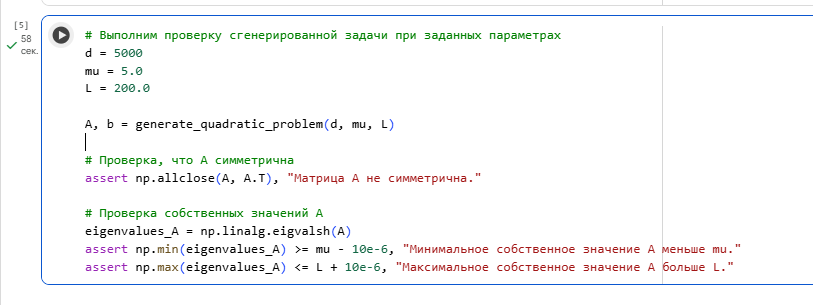

In [ ]:

# Выполним проверку сгенерированной задачи при заданных параметрах
d = 5000
mu = 5.0
L = 200.0

A, b = generate_quadratic_problem(d, mu, L)

# Проверка, что A симметрична
assert np.allclose(A, A.T), "Матрица A не симметрична."

# Проверка собственных значений A
eigenvalues_A = np.linalg.eigvalsh(A)
assert np.min(eigenvalues_A) >= mu - 10e-6, "Минимальное собственное значение A меньше mu."
assert np.max(eigenvalues_A) <= L + 10e-6, "Максимальное собственное значение A больше L."

Напомним, что аналитическое решение данной задачи оптимизации имеет вид

$$ x^* = A^{-1}b.$$

A градиент в точке $x$ равен

$$\nabla f(x) = Ax - b.$$

Критерий сходимости будем использовать:

$$f(x) - f(x^*).$$

Найдите значение $x^*$ для сгенерированной квадратичной задачи, реализуйте функции подсчета значения функции потерь, градиента и критерий.

In [ ]:
# Ваше решение (Code)
np.linalg.solve(A, b)

array([-0.03609876,  0.03843028,  0.01094454, ...,  0.06004985,
        0.01032061,  0.02718756])

In [ ]:
def loss(x, A, b):
    """
    Вычисляет значение квадратичной функции f(x) = 0.5 * x^T A x - b^T x.

    Параметры:
        x (np.array): Точка, в которой вычисляется градиент
        A (np.array): Матрица квадратичной формы
        b (np.array): Вектор линейной части

    Возвращает:
        loss (np.array): Значение функции в точке x
    """
    Ax = A @ x
    return float(0.5 * x.dot(Ax) - b.dot(x))

In [ ]:
def grad(x, A, b):
    """
    Вычисляет градиент квадратичной функции f(x) = 0.5 * x^T A x — b^T x.

    Параметры:
        x (np.array): Точка, в которой вычисляется градиент
        A (np.array): Матрица квадратичной задачи
        b (np.array): Вектор линейной части

    Возвращает:
        grad (np.array): Градиент функции в точке x
    """

    return A @ x - b

In [ ]:
def criterion(x, x_star, A, b, loss):
    """
    Вычисляет функциональный критерий сходимости: f(x) - f(x^*).

    Параметры:
        x (np.array): Текущая точка
        x_star (np.array): Точное решение

    Возвращает:
        criterion (float): Значение критерия
    """

    deltax = x - x_star
    return float(0.5 * deltax.dot(A @ deltax))

__а) (3 балла)__ Реализуйте метод сопряженных градиентов.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальное приближение $x^0 \in \mathbb{R}^d$
- Начальная невязка $r_0 = \nabla f(x^0) $
- Начальное направление поиска $ p_0 = -r_0 $
- Максимальное число итераций $K$

---

$k$_-ая итерация:_

1. Вычислить коэффициент $\alpha_k$:

   $$
   \alpha_k = alpha\_update\_rule(line\_search\_params)
   $$

2. Обновить $x^k$:

   $$
   x^{k+1} = x^k + \alpha_k \cdot p^k
   $$

3. Вычислить невязку:

   $$
   r^{k+1} = \nabla f(x^{k+1})
   $$

4. Вычислить коэффициент $\beta_k$:

   $$
   \beta_k = beta\_update\_rule(beta\_update\_rule\_params)
   $$

5. Обновить направление поиска:

   $$
   p^{k+1} = -r^{k+1} + \beta_k \cdot p^k
   $$

---

_Условие остановки:_

- Достигнуто максимальное число итераций $K$ или $f(x^k) - f(x^*) < \varepsilon$.

---

_Выход:_

- Полученное значение $x^K$.

In [ ]:
def conjugate_gradient_descent(A, b, loss, grad, criterion, x_0, x_star, alpha_update_rule=None,
                               beta_update_rule=None, eps=1e-8, max_iter=1000, **params):
    """
    Метод сопряжённых градиентов.

    Параметры:
        A (np.array): Матрица квадратичной формы
        b (np.array): Вектор линейной части
        loss (Callable): Целевая функция
        grad (Callable): Функция для вычисления градиента
        criterion (Callable): Функция для вычисления критерия сходимости
        x_0 (np.array): Начальная точка
        x_star (np.array): Точное решение
        alpha_update_rule (Callable): Функция для вычисления коэффициента alpha_k.
        beta_update_rule (Callable): Функция для вычисления коэффициента beta_k.
        eps (float): Точность сходимости
        max_iter (int): Максимальное число итераций
        params (dict): Дополнительные параметры:
            params['beta1'] (float): Первый параметр
            params['beta2'] (float): Второй параметр (не используется в правиле Армихо)
            params['alpha_mult'] (float): Множитель для уменьшения шага
            params['line_search_max_iter'] (int): Максимальное число итераций подбора шага
            params['alpha0'] (float): Начальное значение шага

    Возвращает:
        x_k (np.array): Найденное решение
        errors (list): Список значений критерия сходимости на каждой итерации
    """

    values = []
    errors = []

    x_k = np.copy(x_0)
    errors.append(criterion(x_k, x_star, A, b, loss))

    grad_k = grad(x_k, A, b)
    p_k = -grad_k  # Начальное направление — антиградиент

    # Если alpha_update_rule не задан, используем постоянный шаг
    use_fixed_step = alpha_update_rule is None
    fixed_step = params.get('alpha_fixed', 1e-2)

    # Если beta_update_rule не задан, используем фиксированное значение
    use_fixed_beta = beta_update_rule is None
    fixed_beta = params.get('beta_fixed', 0.5)

    for k in tqdm(range(max_iter)):
        # Проверяем, что p_k — направление спуска
        directional_derivative = grad_k.dot(p_k)
        if directional_derivative >= 0:
            p_k = -grad_k

        # alpha_update_rule(A, b, loss, grad, x_k, p_k, params['beta1'], params['beta2'],
        #                   params['alpha_mult'], params['line_search_max_iter'], params['alpha0'])

        # beta_update_rule(A=A, grad_prev=grad_k, grad_next=grad_next, p=p_k)







        # YOUR CODE HERE
        if use_fixed_step:
            alpha_k = fixed_step
        else:
            alpha_k = alpha_update_rule(
                A, b, loss, grad, x_k, p_k,
                params.get('beta1', 0.5),
                params.get('beta2', 0.9),
                params.get('alpha_mult', 0.5),
                params.get('line_search_max_iter', 20),
                params.get('alpha0', 1.0),
            )

        x_k= x_k + alpha_k * p_k
        grad_next= grad(x_k, A, b)

        if use_fixed_beta:
            beta_k = fixed_beta
        else:
            beta_k = beta_update_rule(A=A, grad_prev=grad_k, grad_next=grad_next, p=p_k)

        p_k= -grad_next + beta_k * p_k
        grad_k= grad_next
        values.append(loss(x_k, A, b))















        errors.append(criterion(x_k, x_star, A, b, loss))

        if errors[-1] < eps:
            break

    return x_k, errors

Запустите метод с теоретическими $\alpha_k$:

$$
\alpha_k = -\frac{\langle r^k, p^k \rangle}{\langle p^k, Ap^k \rangle}
$$

и теоретическим $\beta_k$:

$$
\beta_k = \frac{\langle r^{k + 1}, A p^k \rangle}{\langle p^k, Ap^k \rangle}
$$

В качестве начальной точки возьмите нулевой вектор той же размерности, что и решение.

In [ ]:
def alpha_theoretical(A, b, loss, grad, x, p, beta1, beta2, alpha_mult, max_iters, alpha0):
    """
    Подсчет теоретического alpha.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        loss (Callable): Функция потерь
        grad (Callable): Функция вычисления градиента
        x (np.array): Текущая точка
        p (np.array): Направление спуска
        beta1 (float): Нужен для совместимости
        beta2 (float): Нужен для совместимости
        alpha_mult (float): Нужен для совместимости
        max_iters (int): Нужен для совместимости
        alpha0 (float): Нужен для совместимости

    Возвращает:
        alpha (float): Найденное значение alpha
    """



    # YOUR CODE HERE
    r= grad(x, A, b)
    Ap= A @ p
    den= float(p.dot(Ap))


    return float(- r.dot(p) / den)

In [ ]:
def beta_theoretical(A, grad_prev, grad_next, p):
    """
    Подсчет теоретического beta.

    Параметры:
        A (np.array): Матрица признаков
        grad_prev (np.array): Градиент в точке x^k
        grad_next (np.array): Градиент в точке x^{k + 1}
        p (np.array): Направление спуска

    Возвращает:
        beta (float): Найденное значение beta
    """




    # YOUR CODE HERE
    Ap = A @ p
    den = float(p.dot(Ap))
    return float(grad_next.dot(Ap) / den)

In [ ]:
# Ваше решение (Code)

Постройте график сходимости.

  5%|▍         | 49/1000 [00:04<01:33, 10.17it/s]


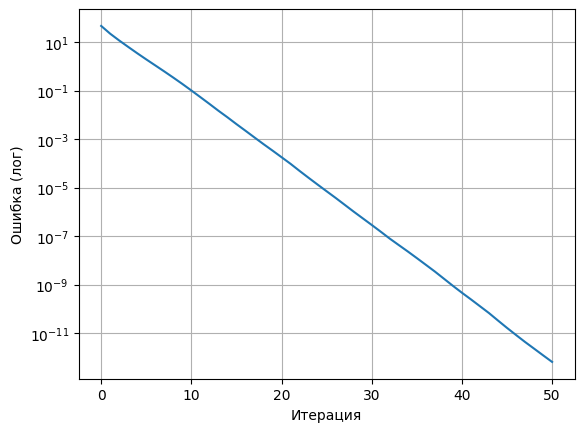

In [ ]:
# Ваше решение (Code)
x_star= np.linalg.solve(A, b)
x0= np.zeros_like(b)

x_theory, error_theory= conjugate_gradient_descent(A, b, loss, grad, criterion, x0, x_star,
    alpha_update_rule=alpha_theoretical, beta_update_rule=beta_theoretical, eps=1e-12,
    max_iter=1000)

plt.figure()
plt.plot(error_theory)
plt.yscale('log')
plt.xlabel("Итерация")
plt.ylabel("Ошибка (лог)")
plt.grid()

__б) (1 балл)__  Запустите метод c постоянными $\alpha_k$ и $\beta_k$. Используйте следующие параметры `alpha_fixed` = $10^{-2}$, `beta_fixed` = $0.5$.

In [ ]:
# Ваше решение (Code)
x_star= np.linalg.solve(A, b)
x0= np.zeros_like(b)

x_fix, error_fixed= conjugate_gradient_descent(A, b, loss, grad, criterion, x0,
    x_star, alpha_update_rule=None, beta_update_rule=None, eps=1e-12, max_iter=1000,
    alpha_fixed=1e-2, beta_fixed=0.5)

 11%|█▏        | 113/1000 [00:06<00:50, 17.68it/s]


Постройте график сходимости с постоянным шагом и с теоретическим шагом.

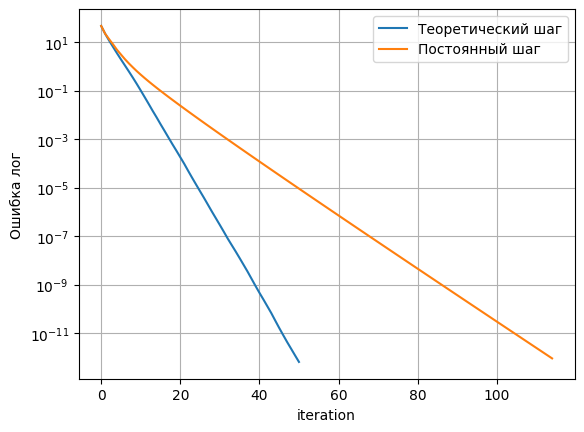

In [ ]:
# Ваше решение (Code)
plt.figure()
plt.plot(error_theory, label="Теоретический шаг")
plt.plot(error_fixed, label="Постоянный шаг")
plt.xlabel("iteration")
plt.ylabel("Ошибка лог")
plt.yscale('log')
plt.grid()
plt.legend()

__в) (3 балла)__ Добавим теперь функции линейного поиска шага. Допишите (см. дополнительную часть задания про ускоренные и оптимальные методы) функцию `armijo` и `strong_wolfe`.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^k$
- Начальная точка $\alpha_0 > 0$
- Направление спуска $p^k$
- Максимальное число итераций $K$
- Множитель уменьшения шага $m \in (0, 1)$
- Параметр $\beta_1 \in (0, 1)$

---

1. Проверить условие Армихо:

$$
f\left(x^k + \alpha_k p^k\right) \leq f\left(x^k\right) + \beta_1 \alpha_k \langle \nabla f(x^k), p^k \rangle
$$

2. Если условие выполнено — вернуть $\alpha_k$. Иначе — уменьшить шаг:

    $$
    \alpha_k = m \cdot \alpha_k
    $$

    и вернуться к 1.

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$

---

_Выход:_
- Полученное значение $\alpha_k$

In [ ]:
def armijo(A, b, loss, grad, x, p, beta1, beta2, alpha_mult, max_iters, alpha0):
    """
    Правило Армихо.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        loss (Callable): Функция потерь
        grad (Callable): Функция вычисления градиента
        x (np.array): Текущая точка
        p (np.array): Направление спуска
        beta1 (float): Параметр условия достаточного убывания
        beta2 (float): Не используется, оставлен для совместимости
        alpha_mult (float): Множитель уменьшения шага
        max_iters (int): Максимальное число итераций подбора
        alpha0 (float): Начальное значение шага

    Возвращает:
        alpha (float): Найденное значение шага, удовлетворяющее условию Армихо
    """
    alpha = alpha0
    counter = 0
    current_loss = loss(x, A, b)
    grad_x = grad(x, A, b)
    directional_derivative = grad_x.dot(p)

    while counter < max_iters:

        # YOUR CODE HERE
        x_new= x + alpha * p
        new_loss= loss(x_new, A, b)

        if new_loss<= current_loss + beta1*alpha*directional_derivative:
            break

        alpha*= alpha_mult
        counter+= 1

    return alpha

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^k$
- Начальная точка $\alpha_0 > 0$
- Направление спуска $p^k$
- Максимальное число итераций $K$
- Множитель уменьшения шага $m \in (0, 1)$
- Параметры $\beta_1, \beta_2 \in (0, 1)$

---

1. Проверить условие Армихо:

$$
f\left(x^k + \alpha_k p^k\right) \leq f\left(x^k\right) + \beta_1 \alpha_k \langle \nabla f\left(x^k\right), p^k \rangle
$$

2. Проверить сильное условие кривизны

$$
|\langle \nabla f \left(x^k + \alpha_k p^k\right),  p^k \rangle| \leq \beta_2 |\langle \nabla f \left(x^k\right), p^k \rangle|
$$

2. Если оба условия выполняются, вернуть $\alpha_k$. Если не выполняется Армихо или направление положительное — уменьшить шаг:

    $$\alpha_k = \alpha_k \cdot m$$

    и вернуться к 1. Иначе — увеличить шаг:

    $$\alpha_k = \alpha_k / m$$

    и вернуться к 1

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$

---

_Выход:_
- Полученное значение $\alpha_k$

In [ ]:
def strong_wolfe(A, b, loss, grad, x, p, beta1, beta2, alpha_mult, max_iters, alpha0):
    """
    Сильное правило Вольфа.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        loss (Callable): Функция потерь
        grad (Callable): Функция вычисления градиента
        x (np.array): Текущая точка
        p (np.array): Направление спуска
        beta1 (float): Параметр условия достаточного убывания
        beta2 (float): Параметр кривизны
        alpha_mult (float): Множитель уменьшения шага
        max_iters (int): Максимальное число итераций подбора
        alpha0 (float): Начальное значение шага

    Возвращает:
        alpha (float): Найденное значение шага, удовлетворяющее условию сильного Вольфа
    """
    alpha = alpha0
    counter = 0
    current_loss = loss(x, A, b)
    grad_x = grad(x, A, b)
    directional_derivative = grad_x.dot(p)

    while counter < max_iters:




        # YOUR CODE HERE
        x_new = x + alpha * p
        new_loss = loss(x_new, A, b)

        if (new_loss > current_loss + beta1*alpha*directional_derivative) or (directional_derivative>= 0):
            alpha *= alpha_mult
            counter += 1
            continue
        grad_new = grad(x_new, A, b)
        if abs(grad_new.dot(p)) > beta2 * abs(directional_derivative):
            alpha /= alpha_mult
            counter += 1
            continue

        break





    return alpha

Запустите метод с линейным поиском Армихо и сильным Вольфом. Используйте параметры $\beta_1 = 10^{-4}$, $\beta_2 = 0.9$, `alpha_mult=0.5`, `line_search_max_iter=100`, $\alpha_0 = 0.5$ при фиксированном $\beta$.

In [ ]:
# Ваше решение (Code)
x_star= np.linalg.solve(A, b)
x0= np.zeros_like(b)

x_armijo, error_armijo= conjugate_gradient_descent(
    A, b, loss, grad, criterion, x0, x_star, alpha_update_rule=armijo,
    beta_update_rule=None, eps=1e-12, max_iter=1000, beta1=1e-4, beta2=0.9,
    alpha_mult=0.5, line_search_max_iter=100, alpha0=0.5, beta_fixed=0.5)

  9%|▊         | 87/1000 [00:17<03:07,  4.88it/s]


In [ ]:
# Ваше решение (Code)
x_wolfe, error_wolfe = conjugate_gradient_descent(A, b, loss, grad, criterion,
    x0, x_star, alpha_update_rule=strong_wolfe, beta_update_rule=None,
    eps=1e-12, max_iter=1000, beta1=1e-4, beta2=0.9, alpha_mult=0.5,
    line_search_max_iter=100, alpha0=0.5, beta_fixed=0.5)

  8%|▊         | 77/1000 [00:26<05:17,  2.91it/s]


Сравните данные методы с результатами из предыдущих пунктов.

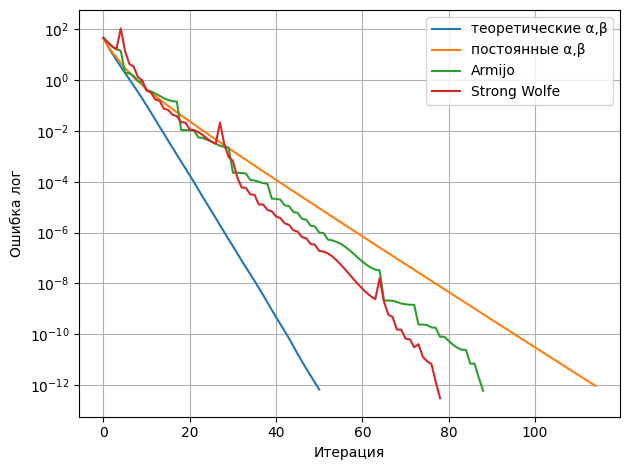

In [ ]:
# Ваше решение (Code)
plt.plot(globals()['error_theory'], label = "теоретические α,β")
plt.plot(globals()['error_fixed'], label = "постоянные α,β")
plt.plot(globals()['error_armijo'], label = "Armijo")
plt.plot(globals()['error_wolfe'], label = "Strong Wolfe")
plt.xlabel("Итерация")
plt.ylabel("Ошибка лог")
plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

__г) (3 балла)__ Теперь перейдем к ключевому элементу — реализации поиска параметра $\beta$ по различным правилам. Рассмотрим три из них:

1. Флетчера-Ривса (FR):

$$
    \beta_{\text{FR}} = \frac{\| r^{k + 1} \|_2^2}{\| r^k \|_2^2}
$$

2. Полака-Рибьера (PRP):

$$
    \beta_{\text{PRP}} = \frac{\langle r^{k + 1}, r^{k + 1} - r^k \rangle}{\| r^k \|_2^2}
$$

3. Хестенса–Штифеля (HF):

$$
    \beta_{\text{HF}} = \frac{\langle r^{k + 1}, r^{k + 1} - r^k \rangle}{\langle p^k, r^{k + 1} - r^k \rangle}
$$

Дополнить код для каждого правила обновления $\beta$.

In [ ]:
def beta_fr(A, grad_prev, grad_next, p):
    """
    Подсчет beta (Флетчера-Ривса).

    Параметры:
        A (np.array): Матрица признаков
        grad_prev (np.array): Градиент в точке x^k
        grad_next (np.array): Градиент в точке x^{k + 1}
        p (np.array): Направление спуска

    Возвращает:
        beta (float): Найденное значение beta
    """





    # YOUR CODE HERE
    num = float(np.dot(grad_next, grad_next))
    den = float(np.dot(grad_prev, grad_prev))





    return num / den

def beta_prp(A, grad_prev, grad_next, p):
    """
    Подсчет beta (Полака-Рибьера).

    Параметры:
        A (np.array): Матрица признаков
        grad_prev (np.array): Градиент в точке x^k
        grad_next (np.array): Градиент в точке x^{k + 1}
        p (np.array): Направление спуска

    Возвращает:
        beta (float): Найденное значение beta
    """






    # YOUR CODE HERE
    y = grad_next - grad_prev
    num = float(np.dot(grad_next, y))
    den = float(np.dot(grad_prev, grad_prev))






    return num / den



def beta_hf(A, grad_prev, grad_next, p):
    """
    Подсчет beta (Хестенса–Штифеля).

    Параметры:
        A (np.array): Матрица признаков
        grad_prev (np.array): Градиент в точке x^k
        grad_next (np.array): Градиент в точке x^{k + 1}
        p (np.array): Направление спуска

    Возвращает:
        beta (float): Найденное значение beta
    """






    # YOUR CODE HERE


    y = grad_next - grad_prev
    num = float(np.dot(grad_next, y))
    den = float(np.dot(p, y))





    return num / den



Проведите анализ работы метода в зависимости от наличия/отсутствия конкретных правил обновления параметров $\alpha$ и $\beta$. Выявите, какой метод предлагает лучшую сходимость.

100%|██████████| 100/100 [00:05<00:00, 19.63it/s]


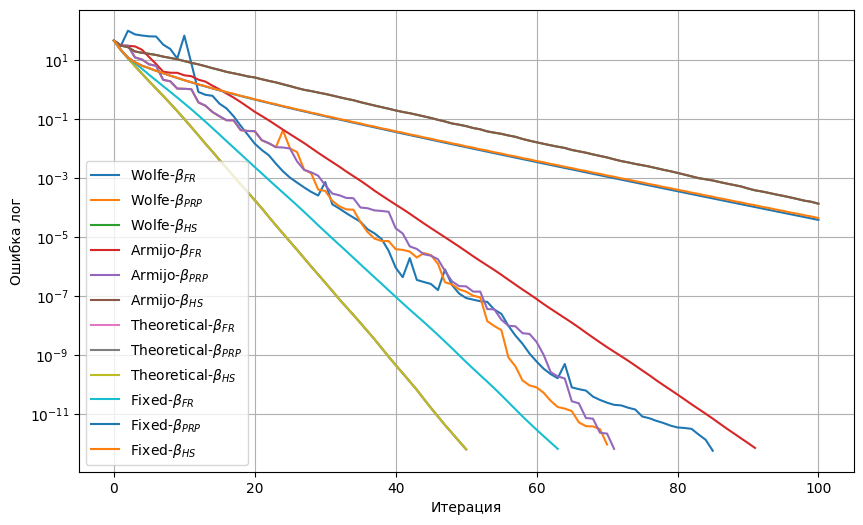

In [ ]:
alpha_rules = [strong_wolfe, armijo, alpha_theoretical, None]
rule_names = ['Wolfe', 'Armijo', 'Theoretical', 'Fixed']
beta_rules = [beta_fr, beta_prp, beta_hf]
beta_names = [r"$\beta_{FR}$", r"$\beta_{PRP}$", r"$\beta_{HS}$"]

x_star = np.linalg.solve(A, b)
x0 = np.zeros_like(b)

common_params = dict(eps=1e-12, max_iter=100, beta1=1e-4, beta2=0.9, alpha_mult=0.5, #Возможно, здесь будет eps=1e-9, но бэкап был для 1e-12 (долго считается)
                    line_search_max_iter=100, alpha0=0.5, alpha_fixed=1e-2)
plt.figure(figsize=(10, 6))

for i, alpha_rule in enumerate(alpha_rules):
    for j, beta_rule in enumerate(beta_rules):
        trs, error = conjugate_gradient_descent(
            A, b, loss, grad, criterion, x0, x_star,alpha_update_rule=alpha_rule,
            beta_update_rule=beta_rule,**common_params)

        label = f"{rule_names[i]}-{beta_names[j]}"
        plt.plot(error, label=label)

plt.xlabel("Итерация")
plt.ylabel("Ошибка лог")
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

Бэкап:

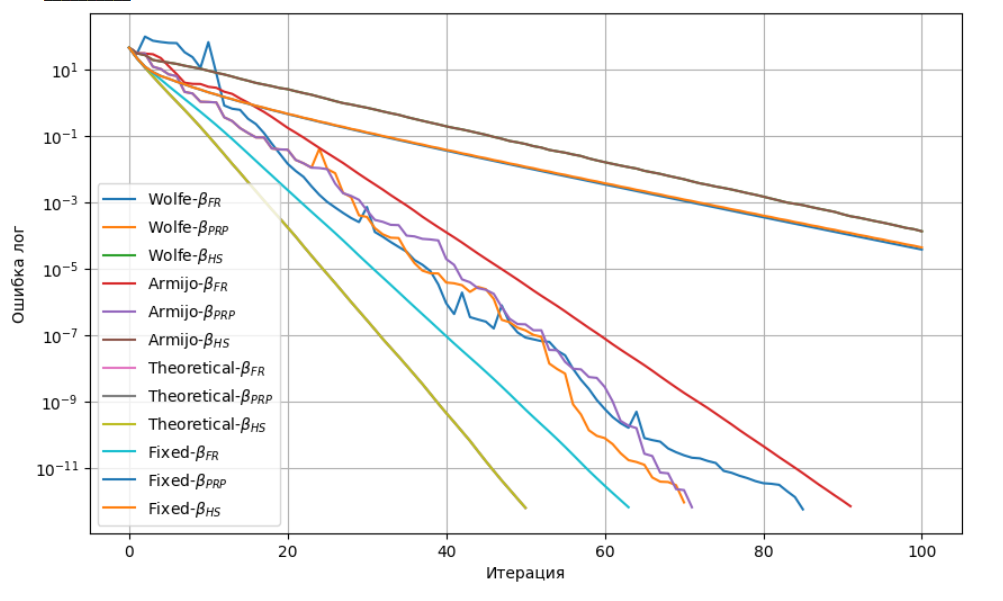

Постройте графики для лучших методов.

 70%|███████   | 70/100 [00:14<00:06,  4.98it/s]


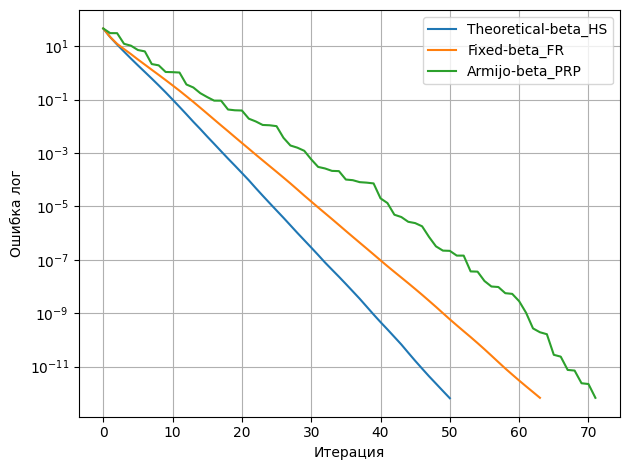

In [ ]:
# Ваше решение (Code)
combinations = [
    (alpha_theoretical, beta_hf, "Theoretical-beta_HS"),
    (None, beta_fr, "Fixed-beta_FR"),
    #(None, beta_hf, "Fixed-beta_HS"),
    (armijo, beta_prp, "Armijo-beta_PRP"),
    #(None, beta_prp, "Fixed-beta_PRP")
]

x_star = np.linalg.solve(A, b)
x0 = np.zeros_like(b)

common_params = dict(eps=1e-12, max_iter=100, beta1=1e-4, beta2=0.9, alpha_mult=0.5,
                    line_search_max_iter=100, alpha0=0.5, alpha_fixed=1e-2)

for alpha_rule, beta_rule, label in combinations:
    trs, error = conjugate_gradient_descent(
        A, b, loss, grad, criterion, x0, x_star, alpha_update_rule=alpha_rule,
        beta_update_rule=beta_rule, **common_params)

    plt.plot(error, label=label)

plt.xlabel("Итерация")
plt.ylabel("Ошибка лог")
plt.yscale("log")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Дополнительная часть (10 баллов)

In [ ]:
from scipy.sparse import csr_matrix, eye
from scipy.sparse.linalg import eigs
import networkx as nx
import requests
import gzip

__Задача 2.__ В данной части мы рассмотрим алгоритм __PageRank__, представленный в 1998 году основателями Google. Для чего он нужен:
- Качественное ранжирование веб-страниц в условиях экспоненциального роста интернета
- Объективная оценка "авторитетности" страниц вне зависимости от содержимого
- Борьба с поисковым спамом и манипуляциями

__Симуляция поиска в интернете__

PageRank моделирует поведение гипотетического пользователя (_Random Surfer_), который:
- С вероятностью $\alpha$ (обычно 0.85) переходит по случайной ссылке на текущей странице
- С вероятностью $1-\alpha$ "телепортируется" на случайную страницу

__Random Surfer Model__

Пусть:

- $n$ — количество веб-страниц
- $P$ — матрица переходов размерности $n \times n$, где $P_{ij} = \begin{cases} \frac{1}{d_i} & \text{если страница } i \text{ ссылается на } j \\ 0 & \text{иначе} \end{cases}$
- $d_i$ — количество исходящих ссылок со страницы $i$

В простейшей модели стохастического графа блужданий верен результат __эргодической теоремы для марковских процессов__, а именно:

Если пустить блуждать человека по графу в течение длительного времени так, что человек будет случайно перемещаться со страницы на страницу согласно весам ребер графа, то доли $\{x_k\}_{k = 1}^n$ времени, которые человек провел на разных страницах, будут удовлетворять следующему уравнению:

$$
\sum_{i = 1}^n x_i P_{ij} = x_j \iff x^{\top} P = x^{\top} \iff x = P^{\top} x,
$$

имеющему единственное решение, удовлетворяющее $\sum \limits_{i = 1}^n x_i = 1$.

__Некоторые проблемы простоты модели случайного блуждания__

- _Проблема 1_: Тупиковые узлы

    Определение: Страницы без исходящих ссылок ($d_i = 0$)

    Проблема: Матрица $P$ становится нестохастической

    Решение: Замена нулевых строк на $\frac{1}{n} \mathbf{1}^{\top}$:
    
    $$
    \tilde{P} = P + \frac{1}{n} \mathbf{d} \mathbf{1}^{\top},
    $$
    
    где $\mathbf{d}$ — индикатор тупиковых узлов

- _Проблема 2_: Несвязность графа

    Определение: Наличие изолированных компонент в графе

    Проблема: Отсутствие эргодичности, неединственность стационарного распределения

    Решение: Добавление телепортации:
    
    $$
    G = \alpha \tilde{P} + (1-\alpha) \frac{1}{n} \mathbf{1} \mathbf{1}^{\top}
    $$

Учитывая все вышеописанные проблемы, решение задачи PageRank принимает следующий вид:

$$
x = G^{\top} x \iff x = \left( \alpha \tilde{P} + (1 - \alpha) \frac{1}{n} \mathbf{1} \mathbf{1}^{\top} \right)^{\top} x \iff x = \left( \alpha \left(P + \frac{1}{n} \mathbf{d} \mathbf{1}^{\top}\right) + (1 - \alpha) \frac{1}{n} \mathbf{1} \mathbf{1}^{\top} \right)^{\top} x.
$$

Раскроем скобки и получим вид задачи в изначальных обозначениях:

$$
x = \alpha \left(P + \frac{1}{n} \mathbf{d} \mathbf{1}^{\top} \right)^{\top} x + (1 - \alpha) \frac{1}{n} \mathbf{1}.
$$

__а) (1 балл)__ Проверьте, что $G^{\top}$ является сжимающим отображением по первой норме.

In [ ]:
# Ваше решение (Markdown)

Пусть <br>
$\tilde P = P + \frac{1}{n}\, \mathbf{d}\,\mathbf{1}^T$ <br>
$G=\alpha \tilde P +(1-\alpha)\frac{1}{n}\mathbf{1}\mathbf{1}^T,\qquad \alpha\in(0,1)$ <br>

Оператор $T(x)=G^T x\$ <br>

Хотим для любых $x,y\in\Delta_n\$ <br>

$||T(x)-T(y)||_1 \le \alpha\,||x-y||_1$ <br>

$T(x)-T(y)=G^T(x-y) = \alpha\,\tilde P^T(x-y) + (1-\alpha)\frac{1}{n}\mathbf{1}\mathbf{1}^T(x-y)$ <br>
$(\mathbf{1}^T x=\mathbf{1}^T y=1)$ => $(\mathbf{1}^T(x-y)=0)$ =>
$\frac{1}{n}\mathbf{1}\mathbf{1}^T(x-y)
= \frac{1}{n}\mathbf{1}\cdot \big(\mathbf{1}^T(x-y)\big) = \mathbf{0}$ <br>
Значит <br>
$T(x)-T(y)=\alpha\,\tilde P^T(x-y)$ <br>

$\max_j \sum_i |(\tilde P^\top)_{ij}| = \max_j \sum_i \tilde P_{ji} = 1 $ => <br>
=> для любого $z\in R^n$: <br>
$\tilde P^\top z||_1 \le ||z||_1$

Применяя к z=x-y: <br>
$||T(x)-T(y)||_1 = \alpha\,||\tilde P^\top(x-y)||_1 \le \alpha\,||x-y||_1$ <br>
=> ЧТД (если $ \alpha \in$ (0,1))


__б) (1 балл)__ Допишите метод простой итерации для нахождения вектора решения $x$. Напомним, что методом простой итерации называют поиск решения для сжимающих отображений $G$ по следующему правилу:

$$
x^{k + 1} = G^{\top} x^k.
$$

_Замечание: после каждой итерации необходима нормировка из-за машинной точности._

In [ ]:
def power_iteration(tilde_P, alpha, max_iter=1000, eps=1e-8):
    """
    Метод простой итерации для решения задачи PageRank

    Параметры:
        tilde_P (csr_matrix): Модифицированная матрица переходов
        alpha (float): Коэффициент затухания
        max_iter (int): Максимальное число итераций
        eps (float): Точность остановки

    Возвращает:
        x (np.array): Вектор PageRank
        residuals (list): История норм невязки
    """
    n = tilde_P.shape[0]
    v = np.ones(n) / n  # Вектор телепортации
    x = np.ones(n) / n  # Начальное приближение
    errors = []

    for i in tqdm(range(max_iter)):







        # YOUR CODE HERE
        x_new= alpha*(tilde_P.T@x) + (1.0-alpha)*v
        s= x_new.sum()
        if s!= 0.0:
            x_new= x_new/s






        # Вычисление невязки
        errors.append(1e6 * np.linalg.norm(x_new - x))

        # Проверка сходимости
        if errors[-1] < eps:
            break

        x = np.copy(x_new)

    return x, errors

__в) (1 балл)__ Сведите задачу PageRank к квадратичной задаче минимизации.

_Замечание: Для уменьшения размера выражения, выразите все через $\tilde{P}$._

In [ ]:
# Ваше решение (Markdown)


$P_t = P + \frac{1}{n}\mathbf{d}\mathbf{1}^T$ <br>
$G = \alpha P_t + (1-\alpha)\frac{1}{n}\mathbf{1}\mathbf{1}^T$ <br>

Вектор PageRank $x^*$ - решениие уравнения:

$x^* = G^T x^*$

$\mathbf{1}^T x^* = 1$ => $(I - \alpha P_t^T) x^* = (1-\alpha)\frac{1}{n}\mathbf{1}$ <br>

Пусть $M = I - \alpha P_t^T$ и $b = (1-\alpha)\frac{1}{n}\mathbf{1}$, => $M x^* = b$

$\rho(\alpha P_t^T) = \alpha < 1$ => $M$ обратима, решение единственно

Условие опт. для квадратичной задачи: <br>
$\min_{x \in \mathbb{R}^n} \frac{1}{2} |Mx - b|_2^2$

$\nabla f(x) = M^T(Mx - b)$ <br>
$\nabla f(x) = 0$ <br>

Значит: <br>

$M^TMx = M^Tb$ <br>

Решения исходной системы и нормальных уравнений совпадают (обратимость M) <br>
Значит, PageRank эквивалентен:

$\min_{x \in \mathbb{R}^n} \frac{1}{2}x^THx - c^Tx + \text{const}$

где $H = M^TM$, $c = M^Tb$.

__г) (2 балла)__ Так как мы теперь умеем сводить задачу к квадратичной, то можно воспользоваться методом сопряженных градиентов, гарантирующий квадратичную сходимость. Допишите метод `conjugate_gradient_pagerank`. Используйте теоретическое значение $\alpha_k$ и $\beta_k = \beta_{FR}$.

_Замечание: используйте функцию `eye` из `scipy.sparse`._

In [ ]:
import scipy.sparse

In [ ]:
def conjugate_gradient_pagerank(tilde_P, alpha, max_iter=1000, eps=1e-8):
    """
    Решение задачи PageRank методом сопряжённых градиентов

    Параметры:
        tilde_P (csr_matrix): Модифицированная матрица переходов
        alpha (float): Коэффициент затухания
        eps (float): Точность остановки
        max_iter (int): Максимальное число итераций

    Возвращает:
        x_k (np.array): Найденное решение
        errors (list): История невязок
    """
    n = tilde_P.shape[0]
    x_0 = np.ones(n) / n # Начальное приближение
    v = np.ones(n) / n  # Вектор телепортации

    I = scipy.sparse.eye(n, format="csr")
    M = I - alpha * tilde_P.T

    A = M.T@M
    b = M.T@((1.0-alpha)*v)

    # Градиент функции потерь
    def grad(x):
        return A @ x - b

    # Критерий остановки
    def criterion(x_new, x_old):
        return np.linalg.norm(x_new - x_old)

    # Инициализация
    errors = []

    x_k = np.copy(x_0)
    grad_k = grad(x_k)
    p_k = -grad_k

    for k in tqdm(range(max_iter)):






        # YOUR CODE HERE

        Ap = A @ p_k
        num = float(grad_k.dot(p_k))
        den = float(p_k.dot(Ap))
        alpha_k = - num / den

        x_new = x_k + alpha_k * p_k
        grad_next = grad(x_new)

        den_b = float(grad_k.dot(grad_k))
        beta_k = float(grad_next.dot(grad_next)) / den_b

        p_k = -grad_next + beta_k * p_k
        grad_k = grad_next


















        errors.append(1e6 * np.linalg.norm(x_new - x_k))

        if errors[-1] < eps:
            break

        x_k = np.copy(x_new)

    x_k /= np.sum(x_k)

    return x_k, errors

__д) (1 балл)__ Теперь сгенерируем саму задачу. Для этого вам нужно дополнить метод `build_transition_matrix`, который должен возвращать стохастическую версию матрицы $P$ (то есть $\tilde{P}$).

_Замечание: используйте функцию `csr_matrix` из `scipy.sparse`._

In [ ]:
def build_transition_matrix(links, n):
    """
    Строит стохастическую матрицу переходов с учётом тупиковых страниц.

    Параметры:
        links (list): Список пар (from, to)
        n (int): Количество страниц

    Возвращает:
        tilde_P (csr_matrix): Модифицированная матрица переходов
    """

    # YOUR CODE HERE

    arr= np.asarray(links, dtype=int).reshape(-1, 2)
    r, c= arr[:, 0], arr[:, 1]
    A= csr_matrix((np.ones(len(arr)), (r, c)), shape=(n, n))

    deg= np.asarray(A.sum(axis=1)).ravel()

    inv= np.divide(1.0, deg, out=np.zeros_like(deg, dtype=float), where=deg > 0)
    Dinv= csr_matrix((inv, (np.arange(n), np.arange(n))), shape=(n, n))
    P= Dinv @ A

    d= (deg == 0).astype(float)
    d_col= csr_matrix(d).T
    one_row= csr_matrix(np.ones((1, n)))
    tilde_P= P + (1.0 / n) * (d_col @ one_row)

    return tilde_P

In [ ]:
def generate_web_graph(n, density=0.1):
    """
    Генерирует случайный граф.
    """
    num_links = int(n * n * density)
    sources = np.random.randint(0, n, num_links)
    targets = np.random.randint(0, n, num_links)
    return list(zip(sources, targets))

In [ ]:
def visualize_web_graph(links, n, pr_vector=None):
    """
    Визуализирует граф с цветами по значению PageRank.
    """
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    G.add_edges_from(links)

    if pr_vector is None:
        pr_vector = np.ones(n) / n

    # Позиции вершин
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(
        G, pos, node_color=pr_vector,
        cmap=plt.cm.viridis, node_size=20, alpha=0.8
    )
    nx.draw_networkx_edges(
        G, pos, edge_color='gray',
        arrowstyle='->', arrowsize=10,
        connectionstyle='arc3,rad=0.1'
    )

    top_pages = np.argsort(pr_vector)[::-1][:5]
    for i, page in enumerate(top_pages):
        x, y = pos[page]
        plt.text(x, y+0.05, f"{page}: {pr_vector[page]:.4f}",
                fontsize=10, ha='center',
                bbox=dict(facecolor='white', alpha=0.7))

    plt.title(f'Веб-граф: {n} страниц, {len(links)} связей')

    ax = plt.gca()

    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), ax=ax, label='PageRank')
    plt.axis('off')
    plt.show()

__е) (2 балл)__ Запустите метод простой итерации и метод сопряженных градиентов.

In [ ]:
# Параметры задачи
n = 1000  # Количество страниц
density = 0.001  # Плотность связей
alpha = 0.85  # Коэффициент затухания
max_iter = 300  # Максимальное число итераций
eps = 1e-16  # Точность остановки

# YOUR CODE HERE

np.random.seed(seed)

links= generate_web_graph(n, density)
tilde_P= build_transition_matrix(links, n)
pr_power, error_power= power_iteration(tilde_P, alpha, max_iter=max_iter, eps=eps)
pr_cg, error_cg= conjugate_gradient_pagerank(tilde_P, alpha, max_iter=max_iter, eps=eps)


100%|██████████| 300/300 [00:00<00:00, 789.40it/s]


Сравните сходимость.

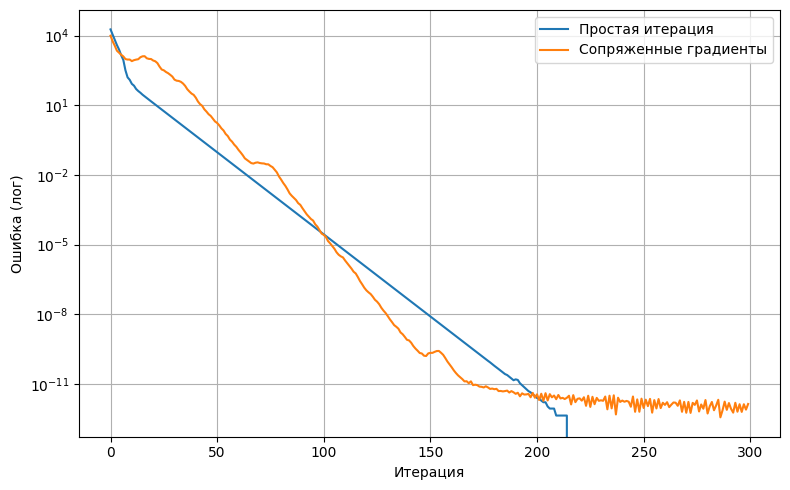

In [ ]:
# Ваше решение (Code)
plt.figure(figsize=(8,5))
plt.plot(error_power, label='Простая итерация')
plt.plot(error_cg,    label='Сопряженные градиенты')
plt.xlabel("Итерация")
plt.ylabel("Ошибка (лог)")
plt.yscale("log")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Визуализируйте графы.

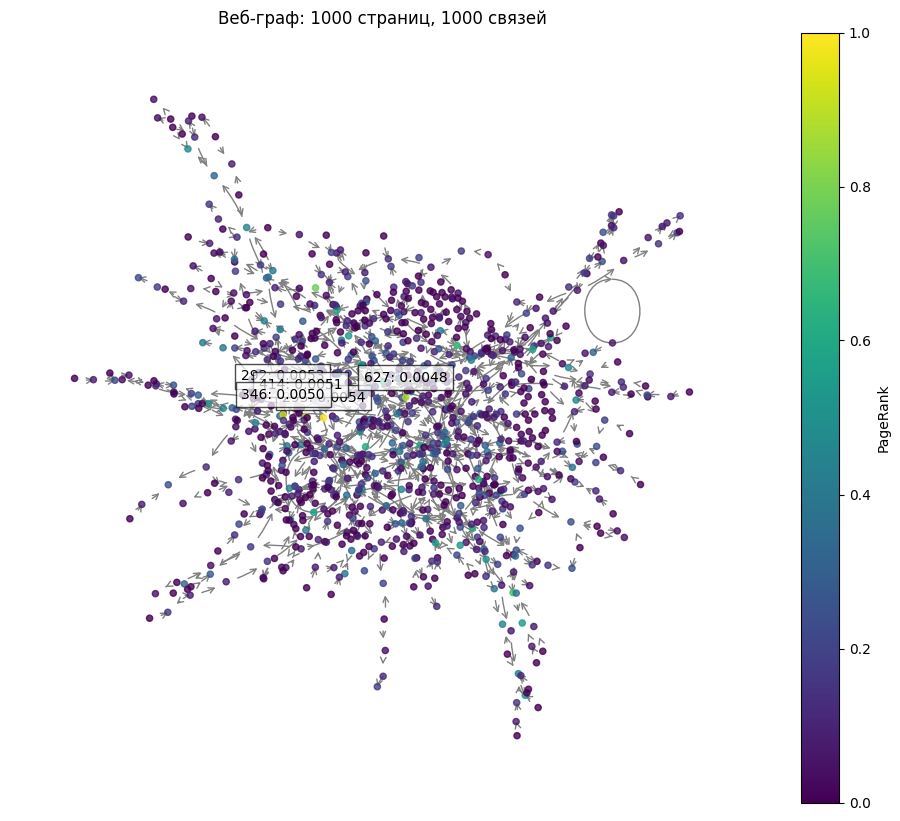

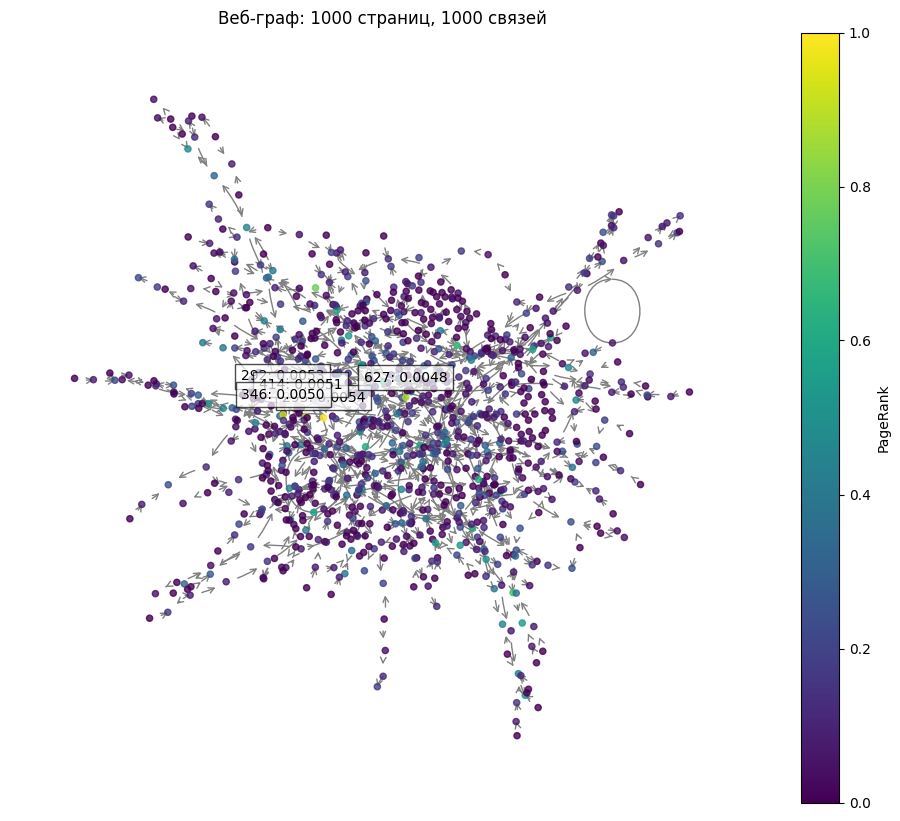

In [ ]:
# Ваше решение (Code)
visualize_web_graph(links, n, pr_vector=pr_power)
visualize_web_graph(links, n, pr_vector=pr_cg)